# TECS ML rotation: What causes a molecule to be lipophilic and how can we predict it?

Lipophilicity is an important feature of drug molecules that affects both membrane permeability and solubility. The lipophilicity dataset, curated from ChEMBL database, provides experimental results of octanol/water distribution coefficient (logD at pH 7.4) of 4200 compounds.
See:
https://deepchem.readthedocs.io/en/latest/api_reference/moleculenet.html#lipo-datasets
And references in there.

**Aims:**
1.	Have a look at the dataset, are there any patterns to it?
2.	What sort of chemical features are associated with lipophilicity?
3.	Train a series of models to predict toxicity, can you beat the state of the art?


In [8]:
# lets load our libraries
import deepchem as dc
from rdkit import Chem
from rdkit.Chem import Draw
import tensorflow as tf

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

import pandas as pd

from matplotlib import pyplot as plt

import numpy as np

In [2]:
# this line loads the Delaney dataset
featurizer=dc.feat.ConvMolFeaturizer()
tasks, datasets, transformers = dc.molnet.load_lipo(featurizer='ECFP')
# the datasets object is already split into the train, validation and test dataset 
train_dataset, valid_dataset, test_dataset = datasets

In [3]:
print(test_dataset)

<DiskDataset X.shape: (420, 1024), y.shape: (420, 1), w.shape: (420, 1), ids: ['O[C@@H](CNCCCOCCNCCc1cccc(Cl)c1)c2ccc(O)c3NC(=O)Sc23'
 'NC1=NN(CC1)c2cccc(c2)C(F)(F)F'
 'COc1cc(ccc1Cn2ccc3ccc(cc23)C(=O)NCC4CCCC4)C(=O)NS(=O)(=O)c5ccccc5' ...
 'CCCSc1ncccc1C(=O)N2CCCC2c3ccncc3' 'Oc1ncnc2scc(c3ccsc3)c12'
 'OC1(CN2CCC1CC2)C#Cc3ccc(cc3)c4ccccc4'], task_names: ['exp']>


In [4]:
f = featurizer.featurize(test_dataset.ids[:12])
f[3]

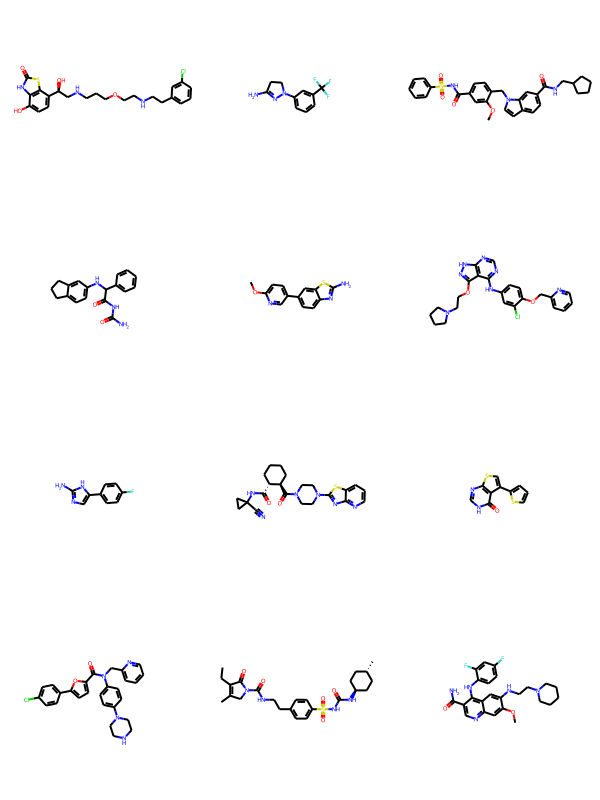

In [5]:
# and this draws a nice image of the 12 molecules
SMILES_strings = test_dataset.ids[:12]
ms = [Chem.MolFromSmiles(x) for x in SMILES_strings]
Draw.MolsToGridImage(ms)

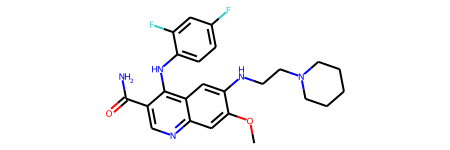

In [6]:
molecule = SMILES_strings[11]
Chem.MolFromSmiles(molecule)

In [7]:
test_dataset.y[11]

array([0.29487808276846605], dtype=object)

(array([ 50.,  89., 138., 242., 375., 524., 649., 679., 454., 160.]),
 array([-3.0247122289148565, -2.529250988365107, -2.0337897478153573,
        -1.5383285072656077, -1.042867266715858, -0.5474060261661085,
        -0.051944785616358846, 0.44351645493339076, 0.9389776954831404,
        1.43443893603289, 1.9299001765826398], dtype=object),
 <BarContainer object of 10 artists>)

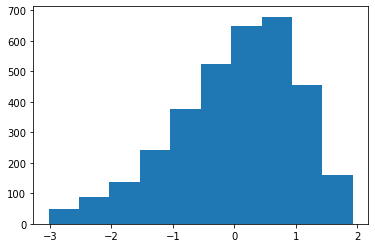

In [117]:
plt.hist(train_dataset.y)

(array([ 50.,  89., 138., 242., 375., 524., 649., 679., 454., 160.]),
 array([-1.5, -0.9, -0.30000000000000004, 0.2999999999999998,
        0.8999999999999999, 1.5, 2.0999999999999996, 2.7, 3.3,
        3.8999999999999995, 4.5], dtype=object),
 <BarContainer object of 10 artists>)

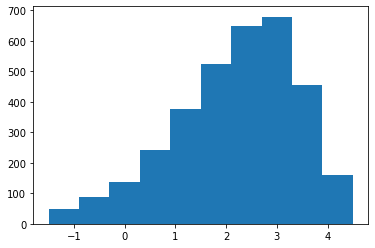

In [118]:
plt.hist(transformers[0].untransform(train_dataset.y))

In [120]:
# this loads in the method used to create the RandomForestRegerssor model
from sklearn.ensemble import RandomForestRegressor

# This line creates a new Random forest regressor object, which we give the name: RF_model
# this is an Sklearn model
RF_model = RandomForestRegressor(n_estimators=100)
# This line tells deepchem that RF_model is a SKleanr model and gives it a new name: model
model = dc.models.SklearnModel(RF_model)
############################################
# Now we fit the training dataset!             #
############################################
model.fit(train_dataset)

In [121]:
# this line tells deepchem what metric to use to score the datasets
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)

# model.evaluate() tests the model. 
# we have to give it the data to use, the metric (or set of metrics) and the transformer used

print("Training set score:", model.evaluate(train_dataset, [metric], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric], transformers))

Training set score: {'pearson_r2_score': 0.9549777075253858}
Test set score: {'pearson_r2_score': 0.2729829659905334}


In [123]:
# this line picks a batch of 12 molecules and gets the predicted solubilities
solubilities = model.predict_on_batch(test_dataset.X[:12])
# this grabs the first 12 smiles strings as well
SMILES_strings = test_dataset.ids[:12]
# this line picks a batch of 12 molecules and gets the predicted solubilities
ground_truth = test_dataset.y[:12]
# this makes an empty list called mol_list
mol_list=[]
print('\tSolubility\t\tMolecule')
print('Predicted\tActual\t\t\n')
# this loops over the numbers 0 to 11 ...
for i in range(12):
    print("{:.3}\t\t{:.3}\t\t{}".format(solubilities[i], ground_truth[i][0], SMILES_strings[i]))

	Solubility		Molecule
Predicted	Actual		

-0.959		-1.81		O[C@@H](CNCCCOCCNCCc1cccc(Cl)c1)c2ccc(O)c3NC(=O)Sc23
0.137		0.32		NC1=NN(CC1)c2cccc(c2)C(F)(F)F
-0.619		-0.192		COc1cc(ccc1Cn2ccc3ccc(cc23)C(=O)NCC4CCCC4)C(=O)NS(=O)(=O)c5ccccc5
-0.199		0.939		NC(=O)NC(=O)C(Nc1ccc2CCCc2c1)c3ccccc3
0.324		0.856		COc1ccc(cn1)c2ccc3nc(N)sc3c2
0.496		0.584		Clc1cc(Nc2ncnc3[nH]nc(OCCN4CCCC4)c23)ccc1OCc5ccccn5
-0.216		-0.638		Nc1ncc([nH]1)c2ccc(F)cc2
-0.266		-0.63		O=C(NC1(CC1)C#N)[C@@H]2CCCC[C@H]2C(=O)N3CCN(CC3)c4nc5ncccc5s4
-1.27		0.0141		O=C1NC=Nc2scc(c3cccs3)c12
0.233		0.691		Clc1ccc(cc1)c2oc(cc2)C(=O)N(Cc3ccccn3)c4ccc(cc4)N5CCNCC5
-1.2		-0.357		CCC1=C(C)CN(C(=O)NCCc2ccc(cc2)S(=O)(=O)NC(=O)N[C@@H]3CC[C@@H](C)CC3)C1=O
0.262		0.295		COc1cc2ncc(C(=O)N)c(Nc3ccc(F)cc3F)c2cc1NCCN4CCCCC4


In [124]:
keras_model = tf.keras.Sequential([
    tf.keras.layers.Dense(1000, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(100, activation='sigmoid'),
    tf.keras.layers.Dense(1)
])
model = dc.models.KerasModel(keras_model, dc.models.losses.L2Loss())

model.fit(train_dataset, nb_epoch=50)
metric = dc.metrics.Metric(dc.metrics.pearson_r2_score)
print('training set score:', model.evaluate(train_dataset, [metric]))
print('test set score:', model.evaluate(test_dataset, [metric]))

training set score: {'pearson_r2_score': 0.9898591342841238}
test set score: {'pearson_r2_score': 0.36780244239830495}


In [119]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(train_dataset.X)

In [75]:
# Create a PCA instance: pca
pca = PCA(n_components=100)

In [76]:
# do the PCA on the x_std matrix, and save the outputs as principalComponents
principalComponents = pca.fit_transform(X_std)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

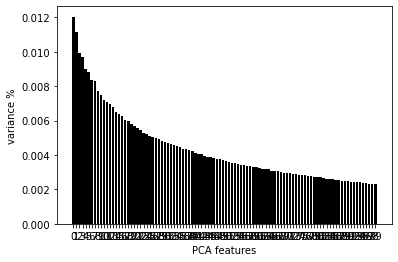

In [77]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

ValueError: x and y must have same first dimension, but have shapes (25,) and (100,)

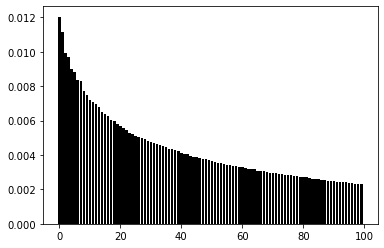

In [78]:
# calculate cumulative sum of explained variances
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.step(range(1,26), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.show()

In [79]:
label_list=[]
for egg in train_dataset.y:
    if 1 < egg < 3:
        egg = 1
    else:
        egg = 0
    label_list.append(egg)

C:\Users\eg16993\Anaconda3\envs\ml-for-chemists\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


Text(0.5, 0, 'PCA 2')

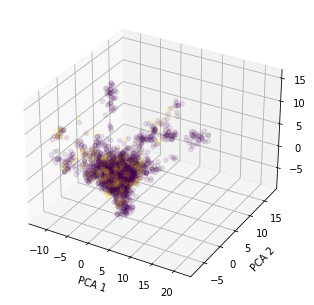

In [80]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(PCA_components[0], PCA_components[1], PCA_components[2], alpha=.1, c=label_list)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Text(0, 0.5, 'PCA 2')

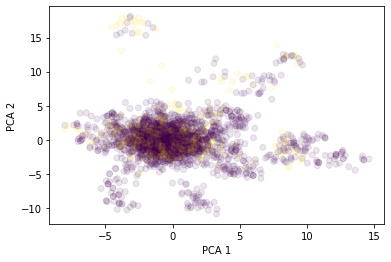

In [81]:
plt.scatter(PCA_components[5], PCA_components[6], alpha=.1, c=label_list)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

In [82]:
PA1, PA2 = [],[]
for i in range(len(label_list)): #: 523 good compounds, 2837 bad compounds
    if label_list[i] == 1:
        PA1.append(PCA_components[0][i])
        PA2.append(PCA_components[1][i])

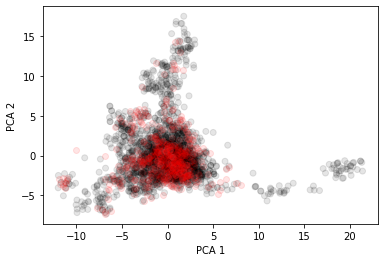

In [86]:
PA1, PA2 = [],[]
for i in range(len(label_list)): #: 523 good compounds, 2837 bad compounds
    if label_list[i] == 1:
        PA1.append(PCA_components[0][i])
        PA2.append(PCA_components[1][i])
        
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, c=label_list, cmap='gray')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.scatter(PA1, PA2, alpha=.1, c='r')

C:\Users\eg16993\Anaconda3\envs\ml-for-chemists\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  


NameError: name 'X' is not defined

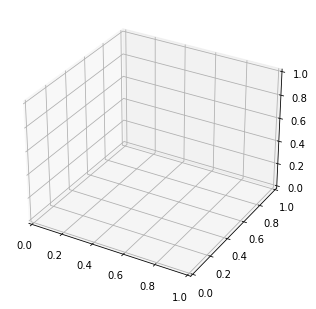

In [74]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2])

Text(0, 0.5, 'PCA 2')

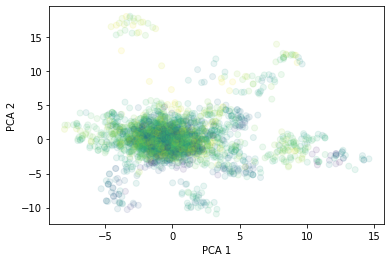

In [56]:
plt.scatter(PCA_components[5], PCA_components[6], alpha=.1, c=train_dataset.y)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Text(0, 0.5, 'PCA 2')

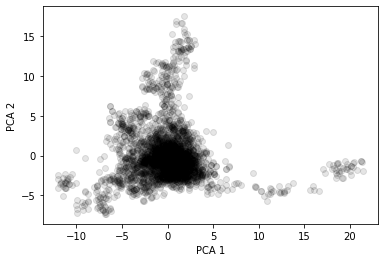

In [12]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

Text(0, 0.5, 'PCA 4')

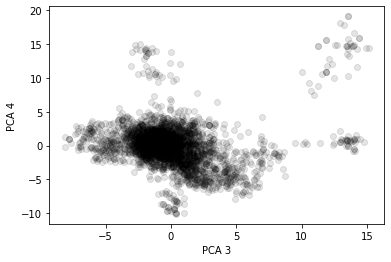

In [13]:
plt.scatter(PCA_components[2], PCA_components[3], alpha=.1, color='black')
plt.xlabel('PCA 3')
plt.ylabel('PCA 4')

In [95]:
kmeans = KMeans(n_clusters=30, init = 'random', max_iter = 1, random_state = 5).fit(train_dataset.X)
kmeans

KMeans(init='random', max_iter=1, n_clusters=30, random_state=5)

In [93]:
kmeans = KMeans(n_clusters=30, init = 'random', max_iter = 1, random_state = 5).fit(train_dataset.X)
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns = list(PCA_components.iloc[:,:30].columns.values))
fig, ax = plt.subplots(1, 1)
labels = kmeans.predict(PCA_components.iloc[:,:30])
ax=plt.scatter(PCA_components[0], PCA_components[1], alpha=1, c=labels, cmap='Set1', marker='D', vmax=8)

ValueError: Shape of passed values is (30, 1024), indices imply (30, 30)

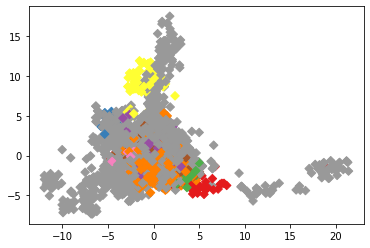

In [91]:
kmeans = KMeans(n_clusters=30, init = 'random', max_iter = 1, random_state = 5).fit(PCA_components.iloc[:,:30])
centroids_df = pd.DataFrame(kmeans.cluster_centers_, columns = list(PCA_components.iloc[:,:30].columns.values))
fig, ax = plt.subplots(1, 1)
labels = kmeans.predict(PCA_components.iloc[:,:30])
ax=plt.scatter(PCA_components[0], PCA_components[1], alpha=1, c=labels, cmap='Set1', marker='D', vmax=8)

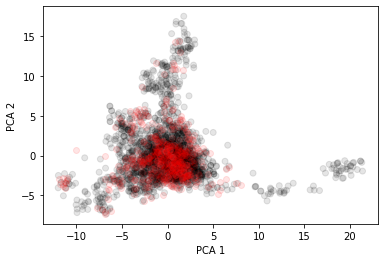

In [92]:
PA1, PA2 = [],[]
for i in range(len(label_list)): #: 523 good compounds, 2837 bad compounds
    if label_list[i] == 1:
        PA1.append(PCA_components[0][i])
        PA2.append(PCA_components[1][i])
        
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, c=label_list, cmap='gray')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.scatter(PA1, PA2, alpha=.1, c='r')

In [79]:
meh = [int(x[0]) for x in train_dataset.y]
meh

[0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


Text(0, 0.5, 'PCA 2')

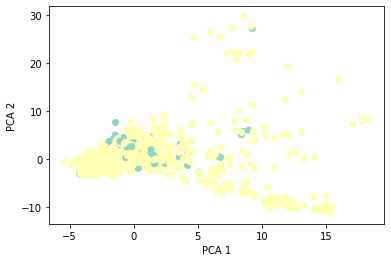

In [93]:
#Actual labels for comparison
plt.scatter(PCA_components[0], PCA_components[1], alpha=1, c=meh, cmap='Set3', marker='o', vmax=9)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
#wine_df.plot.scatter(x = 'Alcohol', y = 'OD280/OD315', c= 'Class', figsize=(12,8), colormap='jet')

In [92]:
## answer
data= train_dataset.X
sse = {}
for k in range(1, 100):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    #data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    print("k is {}: SSE is {}". format(k, sse[k]))
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

k is 1: SSE is 41236.83671742808
k is 2: SSE is 39952.22936852835
k is 3: SSE is 39176.00625444817
k is 4: SSE is 38408.58273397586
k is 5: SSE is 38079.575647650694
k is 6: SSE is 37730.73937142509
k is 7: SSE is 37122.35598350425
k is 8: SSE is 36886.033343788
k is 9: SSE is 36398.69040888209
k is 10: SSE is 36281.529241846794
k is 11: SSE is 36055.97524195575
k is 12: SSE is 35981.99434561358
k is 13: SSE is 35375.11731484879
k is 14: SSE is 35104.73914349006
k is 15: SSE is 34898.97366478202
k is 16: SSE is 34461.42735304876
k is 17: SSE is 34483.42544087735
k is 18: SSE is 34082.202639866664
k is 19: SSE is 34027.40077871662
k is 20: SSE is 33848.35590092592
k is 21: SSE is 33330.16371904472
k is 22: SSE is 33378.706740010886
k is 23: SSE is 33040.41240333482
k is 24: SSE is 32840.97472266138
k is 25: SSE is 32839.915097985024
k is 26: SSE is 32667.42069552392
k is 27: SSE is 32529.00036138828
k is 28: SSE is 32143.855445238005
k is 29: SSE is 31977.432609072195
k is 30: SSE is 31

KeyboardInterrupt: 